In [53]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
# from TransformerNetwork import * 
#from t2v import *

In [39]:
# hyperparameter
window_size = 10
enc_seq_len = window_size
dec_seq_len = 2
output_sequence_length = 1

dim_val = 5 # input data # features
dim_attn = 8
lr = 0.002
epochs = 1

n_heads = 2 

n_decoder_layers = 2
n_encoder_layers = 2

batch_size = 15

# time to vec
time_embed_size = 2

In [206]:
df = pd.read_csv("TSLA.csv")
X = df.iloc[:,1:]
X_simp = df['Close']
Y = df["Close"]
x,y = X_simp.to_numpy(),Y.to_numpy()
sz = 1000
x = x[:sz]
y = y[:sz]

In [207]:
x.shape

(1000,)

In [208]:
Y[:3]

0    47.518002
1    49.397999
2    51.094002
Name: Close, dtype: float64

In [209]:
def sliding_window(x,y, window_size):
    xx, yy = [], []
    for i in range(window_size,len(x)):
        xx.append(x[i-window_size:i])
        yy.append(y[i])
    xx, yy = np.array(xx), np.array(yy)
    return xx, yy

In [210]:
xx,yy = sliding_window(x,y,window_size=window_size)

In [211]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

In [212]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape, sep='\n')

(400,)
(400,)
(200,)
(200,)
(400,)
(400,)


In [213]:
# sinact = SineActivation(5,2)
#q = x_train[:3,:,:].astype(np.float32)
#q =torch.from_numpy(q)
#torch.reshape(q,(15,5))
#a = sinact(q)
#a.reshape()

In [214]:
#q = x_train[:3,:,:].astype(np.float32)
#q =torch.from_numpy(q)
#a = torch.reshape(q,(15,5))
#torch.reshape(a,(3,5,5))

In [215]:
pd.Series(y).describe()

count    1000.000000
mean       60.660038
std        20.545385
min        35.793999
25%        47.085000
50%        59.722001
75%        67.437000
max       183.483994
dtype: float64

In [216]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF

timeseries_adf :  (-9.549086314311868, 2.6010271645465702e-16, 2, 397, {'1%': -3.4469295619737665, '5%': -2.8688478565083417, '10%': -2.570662885558566}, 3379.3151749728527)
timeseries_diff1_adf :  (-7.740216458924227, 1.0668575096859703e-11, 16, 382, {'1%': -3.4475850438570115, '5%': -2.869135963767125, '10%': -2.5708164748773332}, 3414.8220782881995)
timeseries_diff2_adf :  (-9.122053741071413, 3.185694680987596e-15, 17, 380, {'1%': -3.4476763783532585, '5%': -2.869176103659426, '10%': -2.570837873961219}, 3456.579377319078)


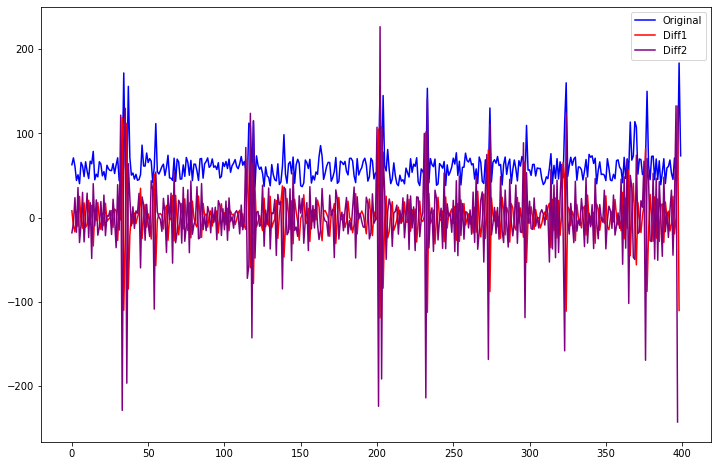

In [217]:
##Chg##
def diff(timeseries):
    timeseries_diff1 = np.diff(timeseries,axis=0)
    timeseries_diff2 = np.diff(timeseries_diff1,axis=0)

    timeseries_adf = ADF(timeseries.tolist())
    timeseries_diff1_adf = ADF(timeseries_diff1.tolist())
    timeseries_diff2_adf = ADF(timeseries_diff2.tolist())

    print('timeseries_adf : ', timeseries_adf)
    print('timeseries_diff1_adf : ', timeseries_diff1_adf)
    print('timeseries_diff2_adf : ', timeseries_diff2_adf)

    plt.figure(figsize=(12, 8))
    plt.plot(timeseries, label='Original', color='blue')
    plt.plot(timeseries_diff1, label='Diff1', color='red')
    plt.plot(timeseries_diff2, label='Diff2', color='purple')
    plt.legend(loc='best')
    plt.show()

diff(x_train)

C:\Users\zixia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


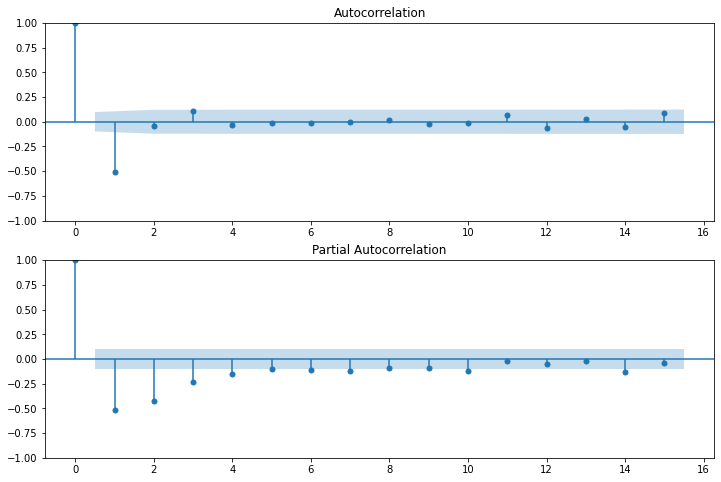

In [218]:
def autocorrelation(timeseries, lags):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()


diff1 = np.diff(x_train,axis=0)
diff1 = np.nan_to_num(diff1)
diff2 = np.diff(diff1,axis=0)
diff2 = np.nan_to_num(diff2)
autocorrelation(diff1, 15)

In [251]:
def ARIMA_Model(timeseries, order):
    model = ARIMA(timeseries, order=order)
    return model.fit()

decomposition = seasonal_decompose(x_train, period=7)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend = np.nan_to_num(trend)
seasonal =  np.nan_to_num(seasonal)
residual =  np.nan_to_num(residual)

# 趋势序列模型训练
trend_model = ARIMA_Model(trend, (2, 0, 3))
trend_fit_seq = trend_model.fittedvalues
trend_predict_seq = trend_model.predict()

# 残差序列模型训练
residual_model = ARIMA_Model(residual, (4, 0, 4))
residual_fit_seq = residual_model.fittedvalues
residual_predict_seq = residual_model.predict()

# 拟合训练集
fit_seq = pd.Series(seasonal)
fit_seq = fit_seq.add(trend_fit_seq, fill_value=0)
fit_seq = fit_seq.add(residual_fit_seq, fill_value=0)

'''
plt.plot(fit_seq, color='red', label='fit_seq')
plt.plot(x_train, color='blue', label='purchase_seq_train')
plt.legend(loc='best')
plt.show()
'''

fit_seq - x_train

# 预测测试集
# 这里测试数据的周期性是根据seasonal对象打印的结果，看到里面的数据每7天一个周期，2014-08-01~2014-08-10的数据正好和2014-04-04~2014-04-13的数据一致
decomposition = seasonal_decompose(x_val, period=7)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend = np.nan_to_num(trend)
seasonal =  np.nan_to_num(seasonal)
residual =  np.nan_to_num(residual)

predict_seq = pd.Series(seasonal)
predict_seq = predict_seq.add(trend_predict_seq)
predict_seq = predict_seq.add(residual_predict_seq)

'''
plt.plot(predict_seq, color='red', label='predict_seq')
plt.plot(x_val, color='blue', label='purchase_seq_test')
plt.legend(loc='best')
plt.show()
'''

train_error = fit_seq / x_train - 1
val_error = predict_seq / x_val - 1
e1 = np.mean(train_error)
e2 = np.mean(val_error)
print('The average training error is {:.2f}%. \nThe average testing error is {:.2f}%.'.format(e1*100,e2*100))


The average training error is 1.27%. 
The average testing error is 7.05%.


C:\Users\zixia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [220]:
trend_predict_seq.shape

(400,)

In [221]:
residual_predict_seq.shape

(400,)

In [244]:
help(sem)

Help on function sem in module scipy.stats._stats_py:

sem(a, axis=0, ddof=1, nan_policy='propagate')
    Compute standard error of the mean.
    
    Calculate the standard error of the mean (or standard error of
    measurement) of the values in the input array.
    
    Parameters
    ----------
    a : array_like
        An array containing the values for which the standard error is
        returned.
    axis : int or None, optional
        Axis along which to operate. Default is 0. If None, compute over
        the whole array `a`.
    ddof : int, optional
        Delta degrees-of-freedom. How many degrees of freedom to adjust
        for bias in limited samples relative to the population estimate
        of variance. Defaults to 1.
    nan_policy : {'propagate', 'raise', 'omit'}, optional
        Defines how to handle when input contains nan.
        The following options are available (default is 'propagate'):
    
          * 'propagate': returns nan
          * 'raise': throws

In [223]:
seasonal_decompose(x_train,period=7)

In [224]:
ARIMA(x_train, order=(2,1,0))

In [225]:
help(ARIMA.fit)

Help on function fit in module statsmodels.tsa.arima.model:

fit(self, start_params=None, transformed=True, includes_fixed=False, method=None, method_kwargs=None, gls=None, gls_kwargs=None, cov_type=None, cov_kwds=None, return_params=False, low_memory=False)
    Fit (estimate) the parameters of the model.
    
    Parameters
    ----------
    start_params : array_like, optional
        Initial guess of the solution for the loglikelihood maximization.
        If None, the default is given by Model.start_params.
    transformed : bool, optional
        Whether or not `start_params` is already transformed. Default is
        True.
    includes_fixed : bool, optional
        If parameters were previously fixed with the `fix_params` method,
        this argument describes whether or not `start_params` also includes
        the fixed parameters, in addition to the free parameters. Default
        is False.
    method : str, optional
        The method used for estimating the parameters of t

In [231]:
torch.cuda.is_available()

False